# Using `gwent` to Calculate Signal-to-Noise Ratios

Here we present a tutorial on how to use `gwent` to calculate SNRs for the instrument models currently implemented (LISA, PTAs, aLIGO, and Einstein Telescope) with the signal being an array of coalescing Binary Black Holes.

First, we import important modules.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.constants import golden_ratio

import astropy.constants as const
import time
import astropy.units as u

import os,sys
current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index('Research')
save_path_idx = splt_path.index('DetectorDesignSensitivities')
save_directory = "/".join(splt_path[0:save_path_idx+1])
top_directory = "/".join(splt_path[0:top_path_idx+1])

gwent_path = top_directory + '/gwent/'

sys.path.insert(0,gwent_path)

import gwent
import gwent.binary as binary
import gwent.detector as detector
import gwent.snr as snr
import gwent.snrplot as snrplot

from Plot_SNR_2 import Plot_SNR

Setting matplotlib preferences and adding a pretty plot function for fig sizes

In [3]:
def get_fig_size(width=7,scale=2.0):
    #width = 3.36 # 242 pt
    base_size = np.array([1, 1/scale/golden_ratio])
    fig_size = width * base_size
    return(fig_size)
mpl.rcParams['figure.dpi'] = 300
#mpl.rcParams['figure.figsize'] = get_fig_size()
mpl.rcParams['text.usetex'] = True
mpl.rc('font',**{'family':'serif','serif':['Times New Roman']})
mpl.rcParams['lines.linewidth'] = 1.3
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 8

We need to get the file directories to load in the instrument files.

In [4]:
load_directory = gwent.__path__[0] + '/LoadFiles/InstrumentFiles/'

## Fiducial Source Creation

To run `snr.Get_SNR_Matrix`, you need to instantiate a source. Since we need to reinitialize a few times, we just put it here as a function.

This is an example for reasonable mass ranges for the particular detector mass regime and the variable ranges limited by the waveform calibration region.

The source parameters must be set (ie. M,q,z,chi1,chi2), but one also needs to set the minima and maxima of the selected SNR axes variables. This takes the form of `source_param = [fiducial_value,minimum,maximum]`

In [5]:
def Initialize_Source(instrument):
    """Initializes a source binary based on the instrument type and returns the source
    """
    
    #q = m2/m1 reduced mass
    q = 1.0
    q_min = 1.0
    q_max = 18.0
    q_list = [q,q_min,q_max]

    #Chi = S_i*L/m_i**2, spins of each mass i
    chi1 = 0.0 #spin of m1
    chi2 = 0.0 #spin of m2
    chi_min = -0.85 #Limits of PhenomD for unaligned spins
    chi_max = 0.85
    chi1_list = [chi1,chi_min,chi_max]
    chi2_list = [chi2,chi_min,chi_max]

    #Redshift
    z_min = 1e-2
    z_max = 1e3

    if isinstance(instrument,detector.GroundBased):
        #Total source mass
        M_ground_source = [10.,1.,1e4]
        #Redshift
        z_ground_source = [0.1,z_min,z_max]

        source = binary.BBHFrequencyDomain(M_ground_source,
                                           q_list,
                                           z_ground_source,
                                           chi1_list,
                                           chi2_list)
    elif isinstance(instrument,detector.SpaceBased):
        M_space_source = [1e6,10.,1e10]
        z_space_source = [1.0,z_min,z_max]
        source = binary.BBHFrequencyDomain(M_space_source,
                                           q_list,
                                           z_space_source,
                                           chi1_list,
                                           chi2_list)
    elif isinstance(instrument,detector.PTA):
        M_pta_source = [1e9,1e8,1e11]
        z_pta_source = [0.1,z_min,z_max]
        source = binary.BBHFrequencyDomain(M_pta_source,
                                           q_list,
                                           z_pta_source,
                                           chi1_list,
                                           chi2_list)
    return source

## Create SNR Matrices and Samples for a Few Examples

The variables for either axis in the SNR calculation can be:

* GLOBAL:

    * 'T_obs' - Detector Observation Time
    
* SOURCE:

    * 'M' - Mass (Solar Units)
    * 'q' - Mass Ratio
    * 'chi1' - Dimensionless Spin of Black Hole 1
    * 'chi2' - Dimensionless Spin of Black Hole 2
    * 'z' - Redshift
    
* GroundBased ONLY:

    * Any single valued variable in list of params given by:
        instrument_GroundBased.Get_Noise_Dict()
    * To make variable in SNR, declare the main variable, then the subparameter variable
        as a string e.g. var_x = 'Infrastructure Length', the case matters.
    
* SpaceBased ONLY:

    * 'L' - Detector Armlength
    * 'A_acc' - Detector Acceleration Noise
    * 'A_IFO' - Detector Optical Metrology Noise
    * 'f_acc_break_low' - The Low Acceleration Noise Break Frequency
    * 'f_acc_break_high' - The High Acceleration Noise Break Frequency
    * 'f_IFO_break' - The Optical Metrology Noise Break Frequency
    
* PTA ONLY:

    * 'n_p' - Number of Pulsars
    * 'sigma' - Root-Mean-Squared Timing Error
    * 'cadence' - Observation Cadence

## Instrument Creation Examples

For each instrument one wants to investigate, you have to assign the fiducial noise and detector values. We do the same reinitialization game here as the source, so each of these are functions.

These examples only assign ranges of calculation for quick variable calculations, but one only needs to set the minima and maxima if they wish to use other selected SNR axes variables.

If loading a detector, the file should be frequency in the first column and either strain, effective strain noise spectral density, or amplitude spectral density in the second column.

The strain tutorial goes into more detail on initializing detectors, so if you get lost, look there!

### Ground Based Detectors

In [6]:
def Initialize_aLIGO():
    #Observing time in years
    T_obs_ground_list = [4*u.yr,1*u.yr,10*u.yr]
    #aLIGO
    noise_dict_aLIGO = {'Infrastructure':
                  {'Length':[3995,1000,1e5]},
                  'Laser':
                  {'Power':[125,10,1e3]},
                  'Seismic':
                  {'Gamma':[0.8,1e-3,1e3]}}
    aLIGO = detector.GroundBased('aLIGO',T_obs_ground_list,noise_dict=noise_dict_aLIGO)
    
    return aLIGO

### Space Based Detectors

In [7]:
def Initialize_LISA():
    T_obs_space_list = [4*u.yr,1*u.yr,10*u.yr]

    #armlength in meters
    L = 2.5e9*u.m
    L_min = 1.0e7*u.m
    L_max = 1.0e11*u.m
    L_list = [L,L_min,L_max]

    #Acceleration Noise Amplitude
    A_acc = 3e-15*u.m/u.s/u.s
    A_acc_min = 1e-16*u.m/u.s/u.s
    A_acc_max = 1e-14*u.m/u.s/u.s
    A_acc_list = [A_acc,A_acc_min,A_acc_max]

    #The Low Acceleration Noise Break Frequency
    f_acc_break_low = .4*u.mHz.to('Hz')*u.Hz
    f_acc_break_low_min = .1*u.mHz.to('Hz')*u.Hz
    f_acc_break_low_max = 1.0*u.mHz.to('Hz')*u.Hz
    f_acc_break_low_list = [f_acc_break_low,f_acc_break_low_min,f_acc_break_low_max]

    #The High Acceleration Noise Break Frequency
    f_acc_break_high = 8.*u.mHz.to('Hz')*u.Hz
    f_acc_break_high_min = 1.*u.mHz.to('Hz')*u.Hz
    f_acc_break_high_max = 10.*u.mHz.to('Hz')*u.Hz
    f_acc_break_high_list = [f_acc_break_high,f_acc_break_high_min,f_acc_break_high_max]

    #The Optical Metrology Noise Break Frequency
    f_IFO_break = 2.*u.mHz.to('Hz')*u.Hz
    f_IFO_break_min = 1.*u.mHz.to('Hz')*u.Hz
    f_IFO_break_max = 10.*u.mHz.to('Hz')*u.Hz
    f_IFO_break_list = [f_IFO_break,f_IFO_break_min,f_IFO_break_max]

    #Detector Optical Metrology Noise
    A_IFO = 10e-12*u.m
    A_IFO_min = 1.0e-13*u.m
    A_IFO_max = 1.0e-10*u.m
    A_IFO_list = [A_IFO,A_IFO_min,A_IFO_max]

    Background = False

    #Values taken from the ESA L3 proposal, Amaro-Seaone, et al., 2017 (https://arxiv.org/abs/1702.00786)
    T_type = 'N'

    LISA_prop1 = detector.SpaceBased('LISA_prop1',
                                     T_obs_space_list,L_list,A_acc_list,
                                     f_acc_break_low_list,f_acc_break_high_list,
                                     A_IFO_list,f_IFO_break_list,
                                     Background=Background,T_type=T_type)
    return LISA_prop1

### PTA Detectors

In [8]:
def Initialize_NANOGrav():
    #NANOGrav calculation using 11.5yr parameters https://arxiv.org/abs/1801.01837
    #Observing time in years
    T_obs_ptas_list = [11.42*u.yr,5*u.yr,30*u.yr]
    #rms timing residuals in seconds
    sigma = 100*u.ns.to('s')*u.s
    sigma_min = 100*u.ns.to('s')*u.s
    sigma_max = 500*u.ns.to('s')*u.s
    sigma_list = [sigma,sigma_min,sigma_max]
    #Number of pulsars
    n_p = 34
    n_p_min = 18
    n_p_max = 200
    n_p_list = [n_p,n_p_min,n_p_max]
    #Avg observation cadence of 1 every 2 weeks in num/year
    cadence = 1/(2*u.wk.to('yr')*u.yr)
    cadence_min = 2/u.yr
    cadence_max = 1/(u.wk.to('yr')*u.yr)
    cadence_list = [cadence,cadence_min,cadence_max]

    #NANOGrav 11.4 yr WN only
    NANOGrav_WN = detector.PTA('NANOGrav_WN',n_p_list,T_obs=T_obs_ptas_list,sigma=sigma_list,cadence=cadence_list)
    return NANOGrav_WN

## SNR Calculations

To actually sample the parameter space, one needs to declare x and y variables that correspond to the variables inside the relavant instrument and/or model for the SNR Calculation.

You will also need to assign Sample Rates for each, this will directly determine how long a calculation will take. I have kept all curves under 100 for paper figures, so I would recommend nothing over that, but I won't tell you what to do!

In [9]:
#Number of SNRMatrix rows
sampleRate_y = 50
#Number of SNRMatrix columns
sampleRate_x = 50

We now use `Get_SNR_Matrix` with the variables given and the data range to sample the space either logrithmically or linearly based on the selection of variables. 
It computes the SNR for each value, then returns the variable ranges used to calculate the SNR for each matrix, then returns the SNRs with size of the `sampleRate_x`X`sampleRate_y`

### aLIGO

#### Varying Source Parameters
Here we calculate the SNR for three source parameters `chi1`,`q`, and `z` using `Get_SNR_Matrix`. For ease of the example, we just do them all at once.

In [10]:
#Variable on y-axis
var_ys = ['chi1','q','z']
#Variable on x-axis
var_x = 'M'
instrument = Initialize_aLIGO()
sample_x_array = []
sample_y_array = []
SNR_array = []
for var_y in var_ys:
    source = Initialize_Source(instrument)
    start = time.time()
    [sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,
                                                       var_x,sampleRate_x,
                                                       var_y,sampleRate_y)
    end = time.time()
    sample_x_array.append(sample_x)
    sample_y_array.append(sample_y)
    SNR_array.append(SNRMatrix)

    print('Model: ',instrument.name + '_' + var_x + '_vs_' + var_y,',',' done. t = : ',end-start)

Model:  aLIGO_M_vs_chi1 ,  done. t = :  16.533813953399658
Model:  aLIGO_M_vs_q ,  done. t = :  15.588494062423706
Model:  aLIGO_M_vs_z ,  done. t = :  12.59247899055481


#### Plotting SNRs
This is just an example of plotting the above SNRs using the `Plot_SNR` function. The function can take a _ton_ of parameters, but for simple plots most of them are unneccessary.

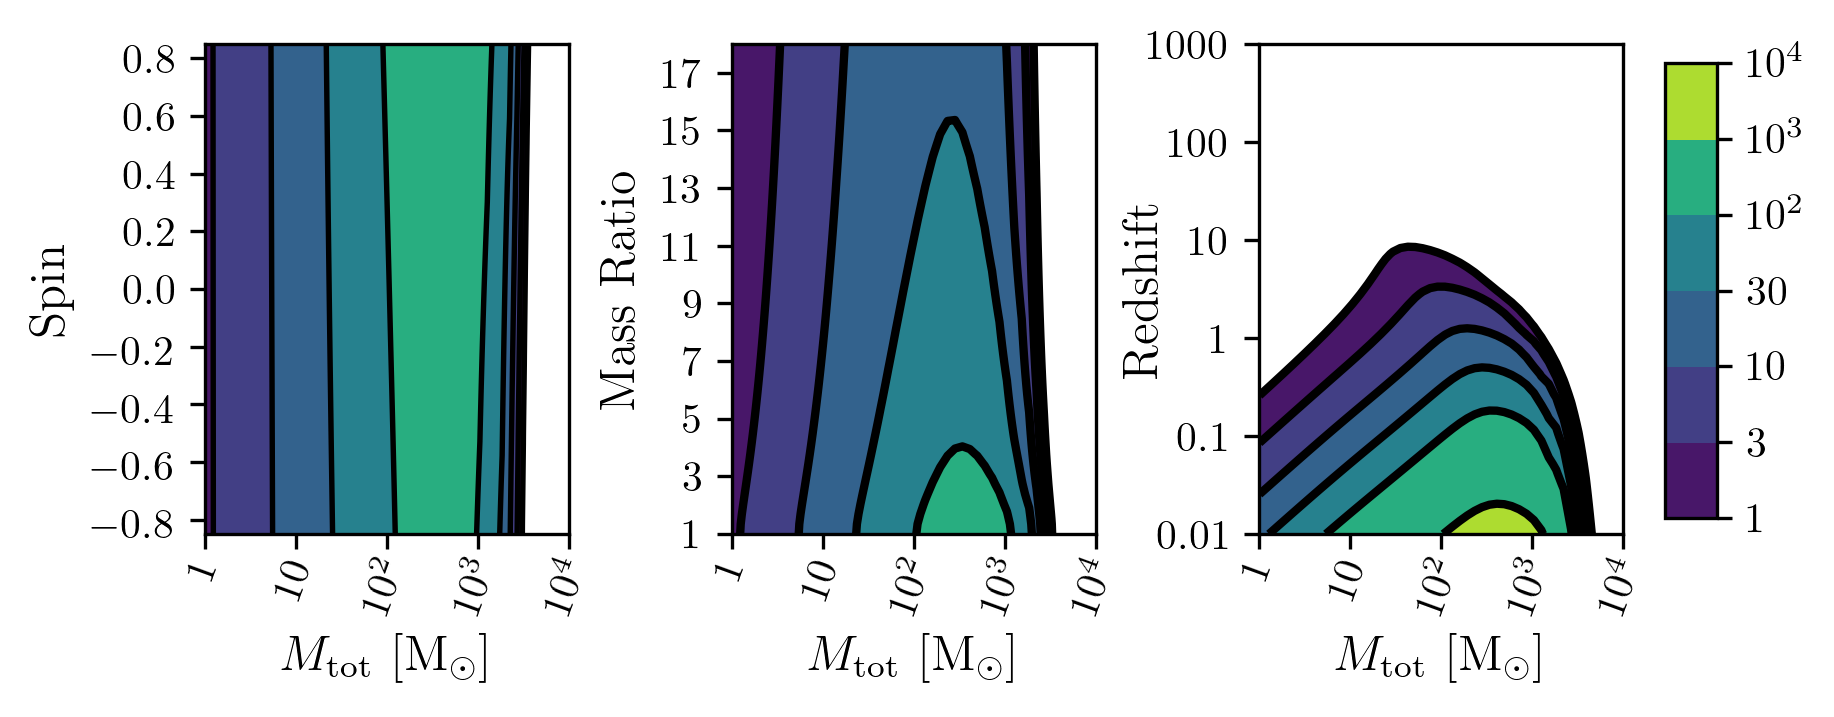

In [11]:
figsize = get_fig_size()
fig, axes = plt.subplots(1,3,figsize=figsize)
loglevelMin=-1.0
loglevelMax=4.0
hspace = .1
wspace = .45

ii = 0
for i,ax in enumerate(axes):
    if ii == (len(axes))-1:
        Plot_SNR('M',sample_x_array[ii],var_ys[ii],
                 sample_y_array[ii],SNR_array[ii],
                 fig=fig,ax=ax,display=True,display_cbar=True,
                 logLevels_min=loglevelMin,logLevels_max=loglevelMax,
                 hspace=hspace,wspace=wspace,
                 xticklabels_kwargs={'rotation':70,'y':0.02},
                 ylabels_kwargs={'labelpad':-5})
    else:
        Plot_SNR('M',sample_x_array[ii],var_ys[ii],
                 sample_y_array[ii],SNR_array[ii],
                 fig=fig,ax=ax,display=False,display_cbar=False,
                 logLevels_min=loglevelMin,logLevels_max=loglevelMax,
                 hspace=hspace,wspace=wspace,xticklabels_kwargs={'rotation':70,'y':0.02})
    ii += 1

A simple example for just one figure.

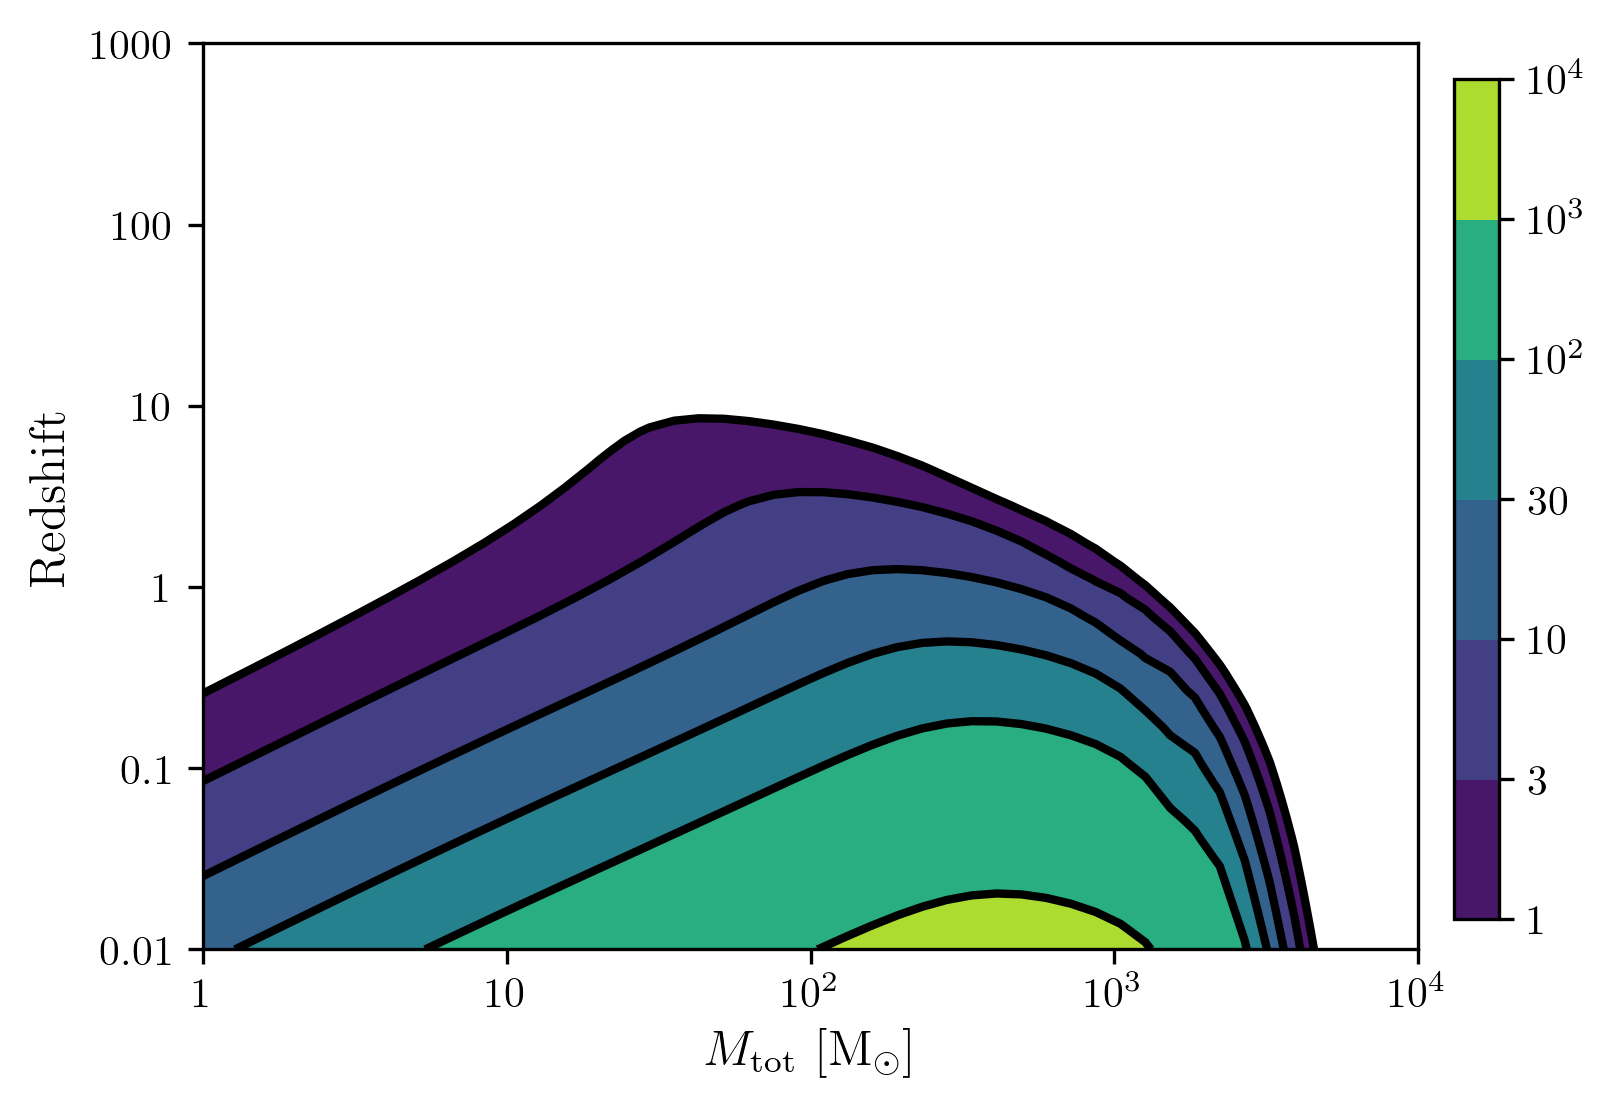

In [12]:
Plot_SNR('M',sample_x_array[-1],'z',sample_y_array[-1],SNR_array[-1])

#### Varying Instrument Parameters

This is very similar to the previous example, but with varying the instrument parameters `Infrastructure Length`, `Seismic Gamma`, and `Laser Power`vs. `M`.

One thing to note is that we moved the instrument initialization inside the for loop this time since we don't want the parameters to stay at the max value from the previous run.

In [13]:
#Variable on y-axis
var_ys = ['Infrastructure Length','Seismic Gamma','Laser Power']
#Variable on x-axis
var_x = 'M'
sample_x_array = []
sample_y_array = []
SNR_array = []
for var_y in var_ys:
    instrument = Initialize_aLIGO()
    source = Initialize_Source(instrument)
    start = time.time()
    [sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,
                                                       var_x,sampleRate_x,
                                                       var_y,sampleRate_y)
    end = time.time()
    sample_x_array.append(sample_x)
    sample_y_array.append(sample_y)
    SNR_array.append(SNRMatrix)

    print('Model: ',instrument.name + '_' + var_x + '_vs_' + var_y,',',' done. t = : ',end-start)

/Users/andrewkaiser/anaconda3/envs/gwent-dev/lib/python3.7/site-packages/gwinc/noise/residualgas.py:40: RuntimeWarning: invalid value encountered in sqrt
  waist = waist * sqrt(((g1*g2)*(1-g1*g2))/((g1+g2-2*g1*g2)**2))
/Users/andrewkaiser/anaconda3/envs/gwent-dev/lib/python3.7/site-packages/gwinc/noise/residualgas.py:54: RuntimeWarning: invalid value encountered in less
  zint[zint < 0] = 0


Model:  aLIGO_M_vs_Infrastructure Length ,  done. t = :  13.003706216812134


/Users/andrewkaiser/anaconda3/envs/gwent-dev/lib/python3.7/site-packages/gwinc/noise/newtonian.py:52: RuntimeWarning: invalid value encountered in true_divide
  coeff = 3**(-gamma*f)/(3**(-gamma*f) + 3**(-gamma*fk))


Model:  aLIGO_M_vs_Seismic Gamma ,  done. t = :  13.108628988265991
Model:  aLIGO_M_vs_Laser Power ,  done. t = :  12.978821039199829


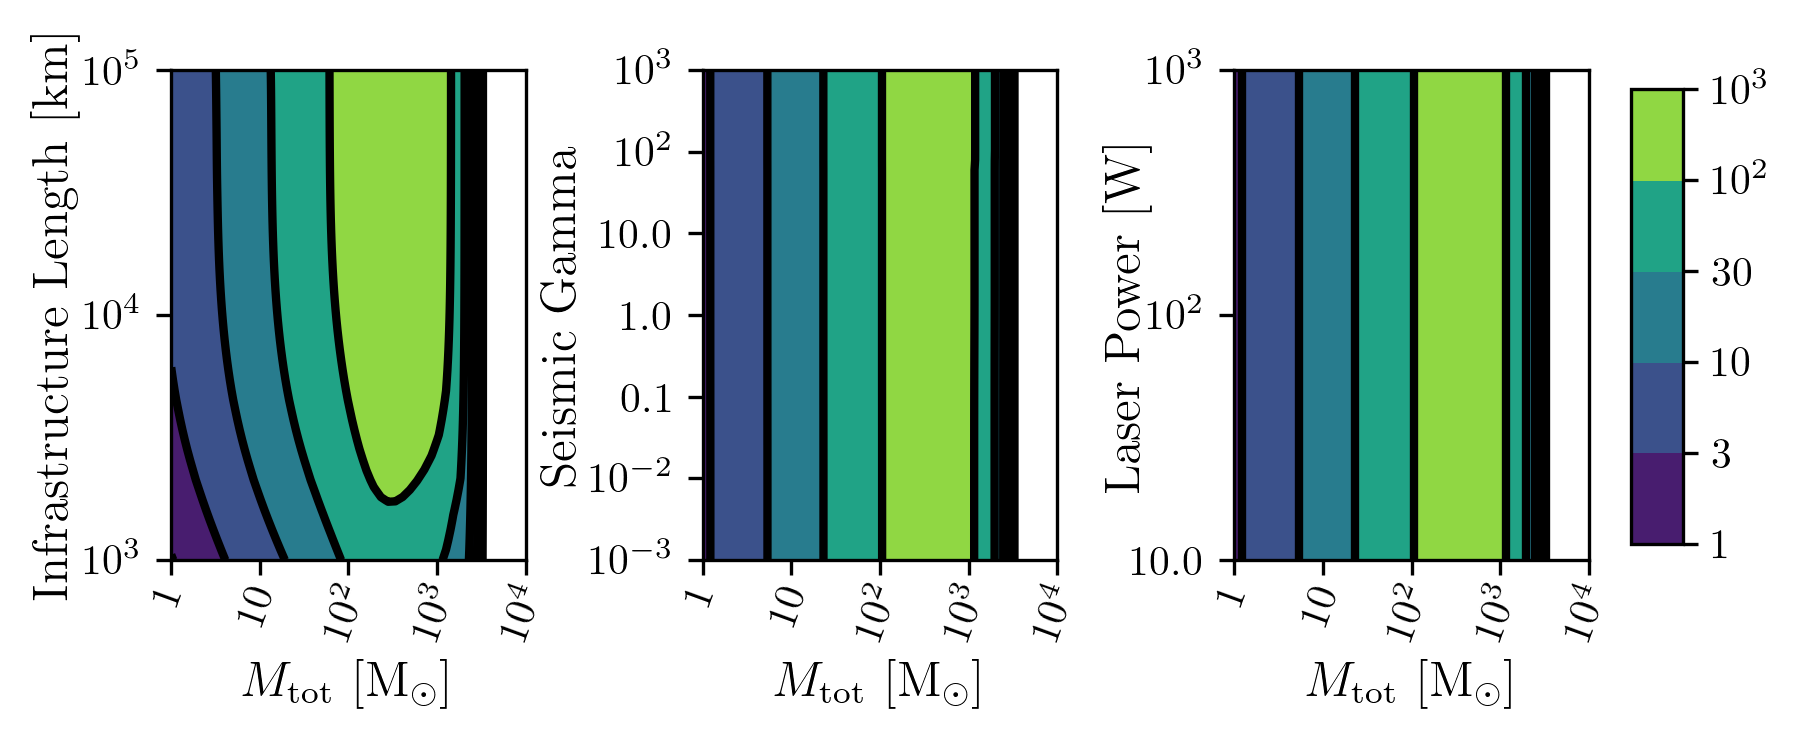

In [14]:
figsize = get_fig_size()
fig, axes = plt.subplots(1,3,figsize=figsize)
loglevelMin=-1.0
loglevelMax=3.0

wspace = .5

ii = 0
for i,ax in enumerate(axes):
    if ii == (len(axes))-1:
        Plot_SNR('M',sample_x_array[ii],var_ys[ii],
                 sample_y_array[ii],SNR_array[ii],
                 fig=fig,ax=ax,display=True,display_cbar=True,
                 logLevels_min=loglevelMin,logLevels_max=loglevelMax,
                 hspace=hspace,wspace=wspace,
                 xticklabels_kwargs={'rotation':70,'y':0.02},ylabels_kwargs={'labelpad':-5})
    else:
        Plot_SNR('M',sample_x_array[ii],var_ys[ii],
                 sample_y_array[ii],SNR_array[ii],
                 fig=fig,ax=ax,display=False,display_cbar=False,
                 logLevels_min=loglevelMin,logLevels_max=loglevelMax,
                 xticklabels_kwargs={'rotation':70,'y':0.02},
                 ylabels_kwargs={'labelpad':1})
    ii += 1

### LISA SNR

We now just for examples repeat the above few SNR calculations for LISA parameters.

In [54]:
#Variable on y-axis
var_ys = ['chi1','q','z']
#Variable on x-axis
var_x = 'M'
instrument = Initialize_LISA()
sample_x_array = []
sample_y_array = []
SNR_array = []
for var_y in var_ys:
    source = Initialize_Source(instrument)
    start = time.time()
    [sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,
                                                       var_x,sampleRate_x,
                                                       var_y,sampleRate_y)
    end = time.time()
    sample_x_array.append(sample_x)
    sample_y_array.append(sample_y)
    SNR_array.append(SNRMatrix)

    print('Model: ',instrument.name + '_' + var_x + '_vs_' + var_y,',',' done. t = : ',end-start)

Model:  LISA_prop1_M_vs_chi1 ,  done. t = :  19.53570795059204
Model:  LISA_prop1_M_vs_q ,  done. t = :  19.665607929229736
Model:  LISA_prop1_M_vs_z ,  done. t = :  16.917686223983765


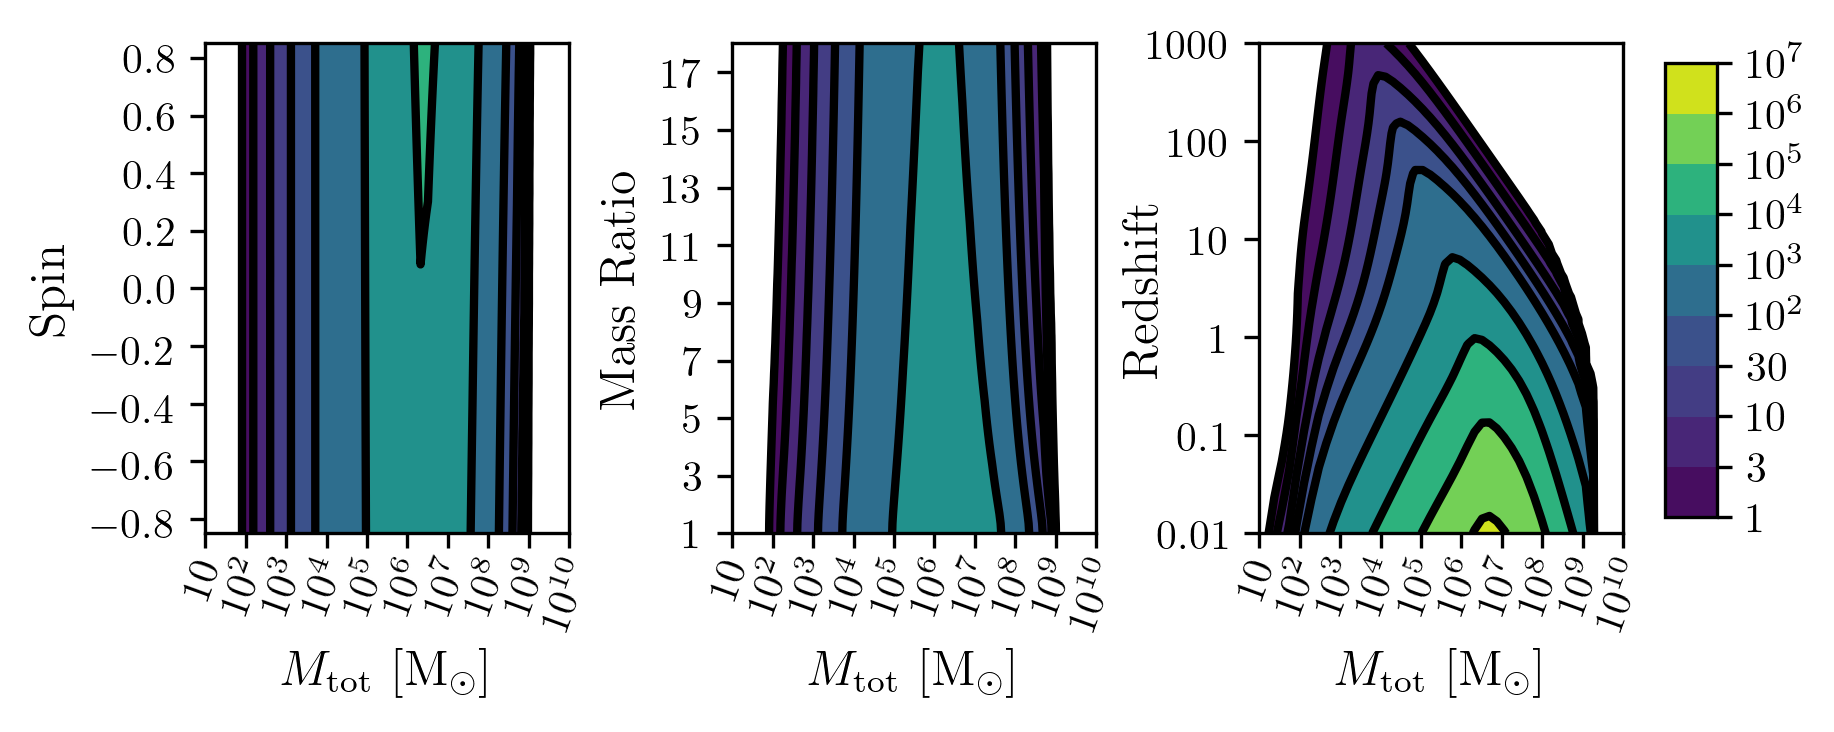

In [55]:
figsize = get_fig_size()
fig, axes = plt.subplots(1,3,figsize=figsize)
loglevelMin=-1.0
loglevelMax=7.0
hspace = .1
wspace = .45

ii = 0
for i,ax in enumerate(axes):
    if ii == (len(axes))-1:
        Plot_SNR('M',sample_x_array[ii],var_ys[ii],
                 sample_y_array[ii],SNR_array[ii],
                 fig=fig,ax=ax,display=True,display_cbar=True,
                 logLevels_min=loglevelMin,logLevels_max=loglevelMax,
                 hspace=hspace,wspace=wspace,
                 xticklabels_kwargs={'rotation':70,'y':0.02},
                 ylabels_kwargs={'labelpad':-5})
    else:
        Plot_SNR('M',sample_x_array[ii],var_ys[ii],
                 sample_y_array[ii],SNR_array[ii],
                 fig=fig,ax=ax,display=False,display_cbar=False,
                 logLevels_min=loglevelMin,logLevels_max=loglevelMax,
                 hspace=hspace,wspace=wspace,xticklabels_kwargs={'rotation':70,'y':0.02})
    ii += 1

Another included feature is the ability to add luminosity distance or lookback times onto the right hand axes of the redshift vs. total mass plots.

2.0
2.0


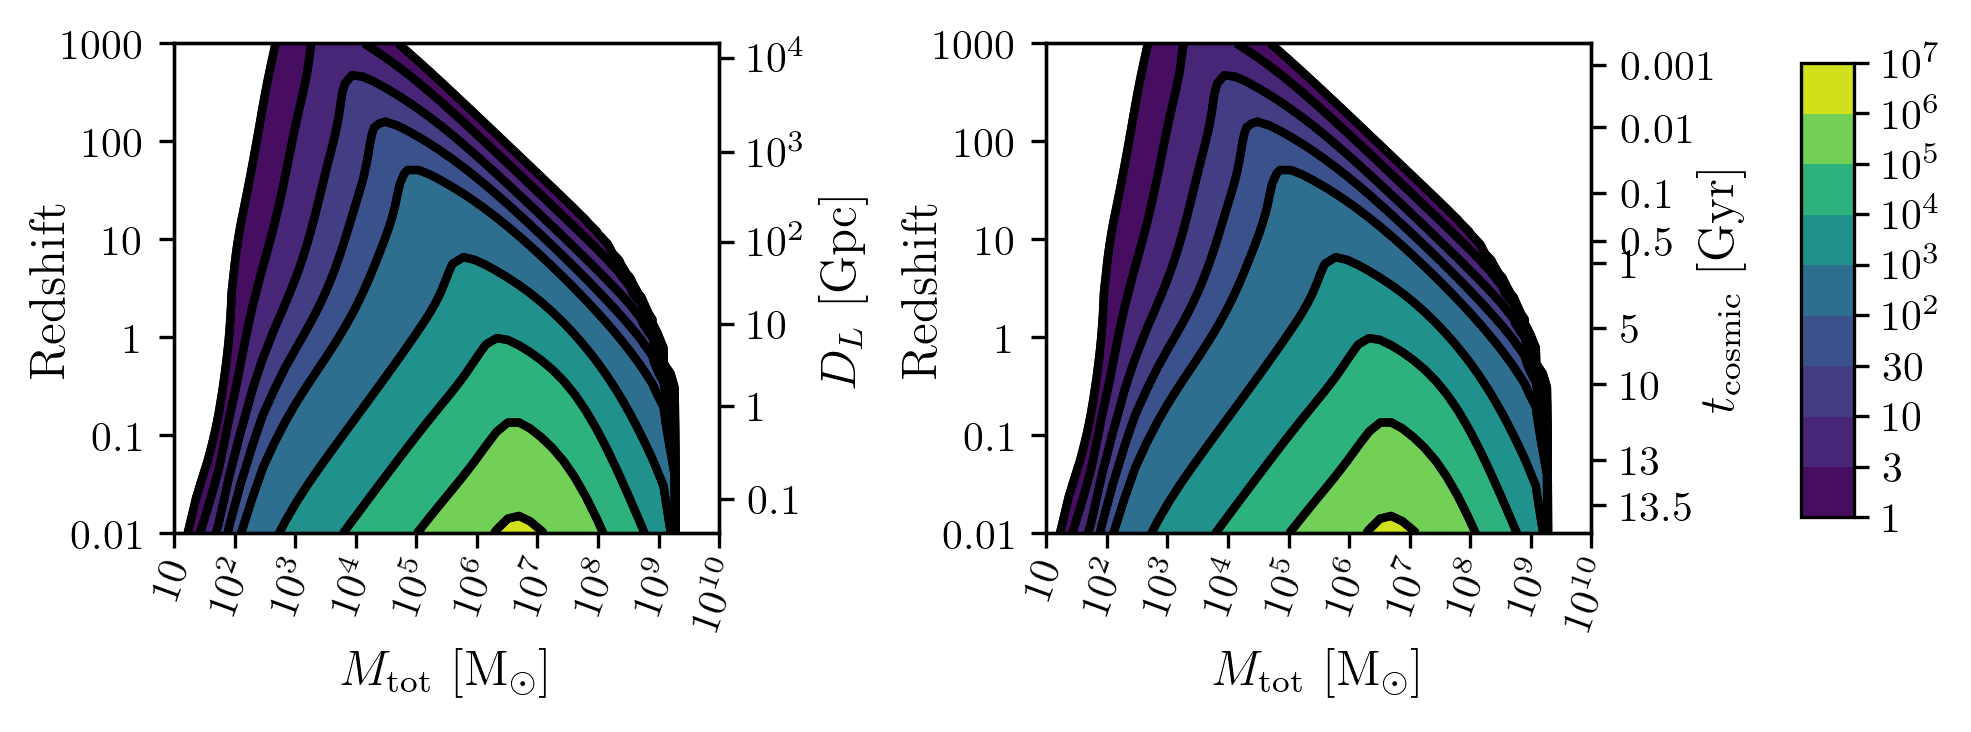

In [78]:
figsize = get_fig_size()
fig, axes = plt.subplots(1,2,figsize=figsize)
wspace = 0.6
Plot_SNR('M',sample_x_array[-1],'z',sample_y_array[-1],SNR_array[-1],fig=fig,ax=axes[0],
         display=False,display_cbar=False,dl_axis=True,
         xticklabels_kwargs={'rotation':70,'y':0.02},
         ylabels_kwargs={'labelpad':-3})
Plot_SNR('M',sample_x_array[-1],'z',sample_y_array[-1],SNR_array[-1],fig=fig,ax=axes[1],
         lb_axis=True,wspace=wspace,xticklabels_kwargs={'rotation':70,'y':0.02},
         ylabels_kwargs={'labelpad':-3})

In [53]:
#Variable on y-axis
var_ys = ['L','A_acc','A_IFO','f_acc_break_low','f_acc_break_high','f_IFO_break']
#Variable on x-axis
var_x = 'M'
sample_x_array = []
sample_y_array = []
SNR_array = []
for var_y in var_ys:
    instrument = Initialize_LISA()
    source = Initialize_Source(instrument)
    start = time.time()
    [sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,
                                                       var_x,sampleRate_x,
                                                       var_y,sampleRate_y)
    end = time.time()
    sample_x_array.append(sample_x)
    sample_y_array.append(sample_y)
    SNR_array.append(SNRMatrix)

    print('Model: ',instrument.name + '_' + var_x + '_vs_' + var_y,',',' done. t = : ',end-start)

KeyboardInterrupt: 

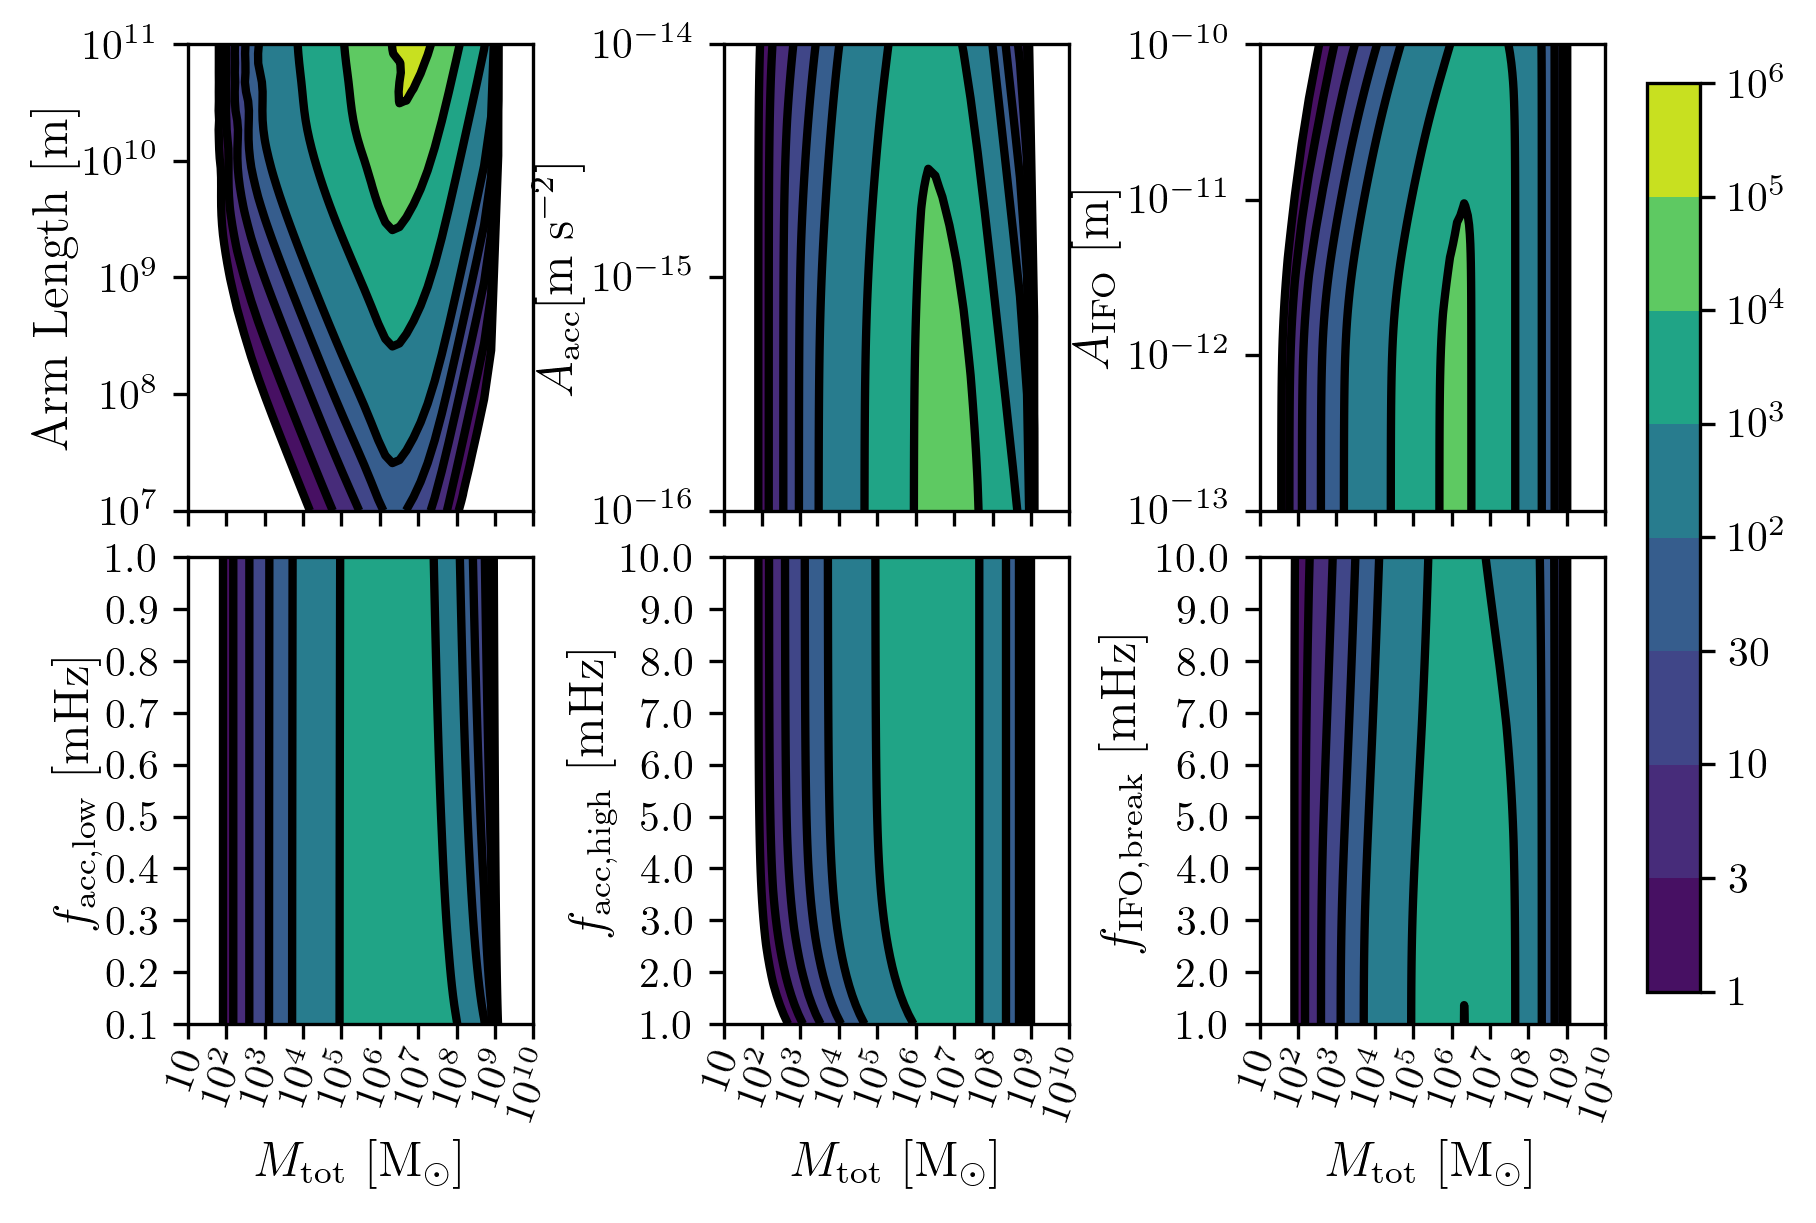

In [18]:
figsize = get_fig_size(scale=1.0)
fig, axes = plt.subplots(2,3,figsize=figsize)

loglevelMin=-1.0
loglevelMax=6.0
hspace = .1
wspace = .55

ii = 0
for i in range(np.shape(axes)[0]):
    for j in range(np.shape(axes)[1]):
        if ii == (np.shape(axes)[0]*np.shape(axes)[1])-1:
            Plot_SNR('M',sample_x_array[ii],var_ys[ii],
                     sample_y_array[ii],SNR_array[ii],
                     fig=fig,ax=axes[i,j],display=True,display_cbar=True,
                     logLevels_min=loglevelMin,logLevels_max=loglevelMax,
                     hspace=hspace,wspace=wspace,
                     xticklabels_kwargs={'rotation':70,'y':0.02},
                     ylabels_kwargs={'labelpad':1})
        elif ii in [(np.shape(axes)[0]*np.shape(axes)[1])-2,(np.shape(axes)[0]*np.shape(axes)[1])-3]:
            Plot_SNR('M',sample_x_array[ii],var_ys[ii],
                     sample_y_array[ii],SNR_array[ii],
                     fig=fig,ax=axes[i,j],display=False,display_cbar=False,
                     logLevels_min=loglevelMin,logLevels_max=loglevelMax,
                     hspace=hspace,wspace=wspace,
                     xticklabels_kwargs={'rotation':70,'y':0.02},
                     ylabels_kwargs={'labelpad':0})
        else:
            Plot_SNR('M',sample_x_array[ii],var_ys[ii],
                     sample_y_array[ii],SNR_array[ii],
                     fig=fig,ax=axes[i,j],display=False,display_cbar=False,x_axis_label=False,
                     logLevels_min=loglevelMin,logLevels_max=loglevelMax,
                     hspace=hspace,wspace=wspace,
                     xticklabels_kwargs={'rotation':70,'y':0.02},
                     ylabels_kwargs={'labelpad':1})
        ii += 1

### PTA SNRs

Same as the rest, just for example purposes!

In [19]:
#Variable on y-axis
var_ys = ['chi1','q','z']
#Variable on x-axis
var_x = 'M'
instrument = Initialize_NANOGrav()
sample_x_array = []
sample_y_array = []
SNR_array = []
for var_y in var_ys:
    source = Initialize_Source(instrument)
    start = time.time()
    [sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,
                                                       var_x,sampleRate_x,
                                                       var_y,sampleRate_y)
    end = time.time()
    sample_x_array.append(sample_x)
    sample_y_array.append(sample_y)
    SNR_array.append(SNRMatrix)

    print('Model: ',instrument.name + '_' + var_x + '_vs_' + var_y,',',' done. t = : ',end-start)

Model:  NANOGrav_WN_M_vs_chi1 ,  done. t = :  13.616463899612427
Model:  NANOGrav_WN_M_vs_q ,  done. t = :  9.559818983078003
Model:  NANOGrav_WN_M_vs_z ,  done. t = :  9.90362000465393


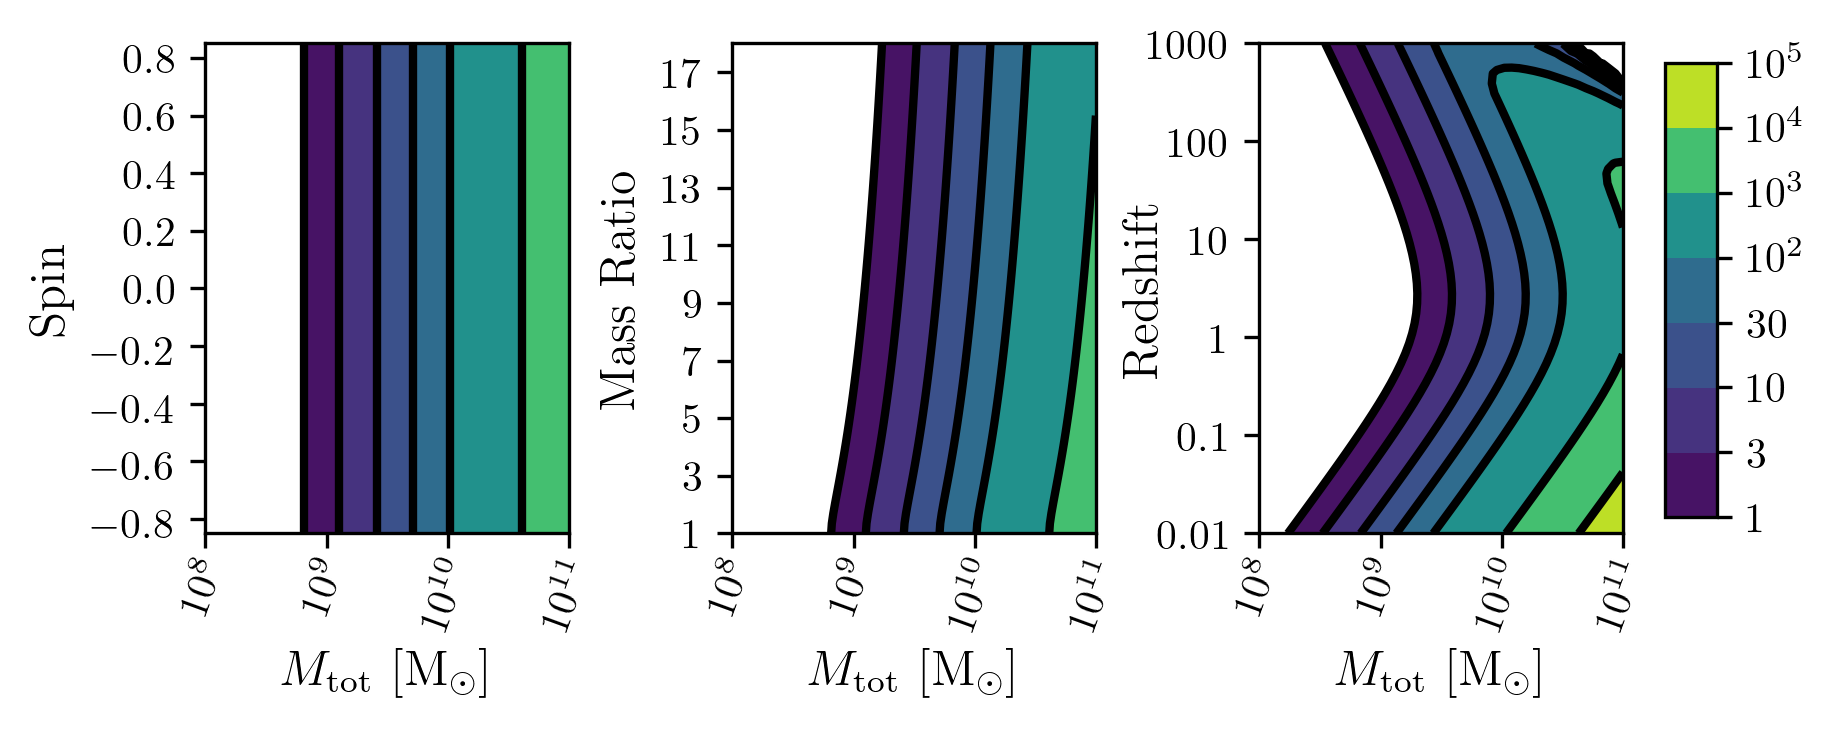

In [21]:
figsize = get_fig_size()
fig, axes = plt.subplots(1,3,figsize=figsize)
loglevelMin=-1.0
loglevelMax=5.0
hspace = .1
wspace = .45

ii = 0
for i,ax in enumerate(axes):
    if ii == (len(axes))-1:
        Plot_SNR('M',sample_x_array[ii],var_ys[ii],
                 sample_y_array[ii],SNR_array[ii],
                 fig=fig,ax=ax,display=True,display_cbar=True,
                 logLevels_min=loglevelMin,logLevels_max=loglevelMax,
                 hspace=hspace,wspace=wspace,
                 xticklabels_kwargs={'rotation':70,'y':0.02},
                 ylabels_kwargs={'labelpad':-5})
    else:
        Plot_SNR('M',sample_x_array[ii],var_ys[ii],
                 sample_y_array[ii],SNR_array[ii],
                 fig=fig,ax=ax,display=False,display_cbar=False,
                 logLevels_min=loglevelMin,logLevels_max=loglevelMax,
                 hspace=hspace,wspace=wspace,xticklabels_kwargs={'rotation':70,'y':0.02})
    ii += 1

These can take a long time if you vary the instrument parameters. Be careful with your sample rates!

In [104]:
#Variable on y-axis
var_ys = ['n_p','sigma','cadence','T_obs']
#Variable on x-axis
var_x = 'M'
sample_x_array = []
sample_y_array = []
SNR_array = []
for var_y in var_ys:
    instrument = Initialize_NANOGrav()
    source = Initialize_Source(instrument)
    start = time.time()
    [sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,
                                                       var_x,sampleRate_x,
                                                       var_y,sampleRate_y)
    end = time.time()
    sample_x_array.append(sample_x)
    sample_y_array.append(sample_y)
    SNR_array.append(SNRMatrix)

    print('Model: ',instrument.name + '_' + var_x + '_vs_' + var_y,',',' done. t = : ',end-start)

Model:  NANOGrav_WN_M_vs_n_p ,  done. t = :  174.2895691394806
Model:  NANOGrav_WN_M_vs_sigma ,  done. t = :  219.42855978012085
Model:  NANOGrav_WN_M_vs_cadence ,  done. t = :  265.46685314178467
Model:  NANOGrav_WN_M_vs_T_obs ,  done. t = :  427.2418489456177


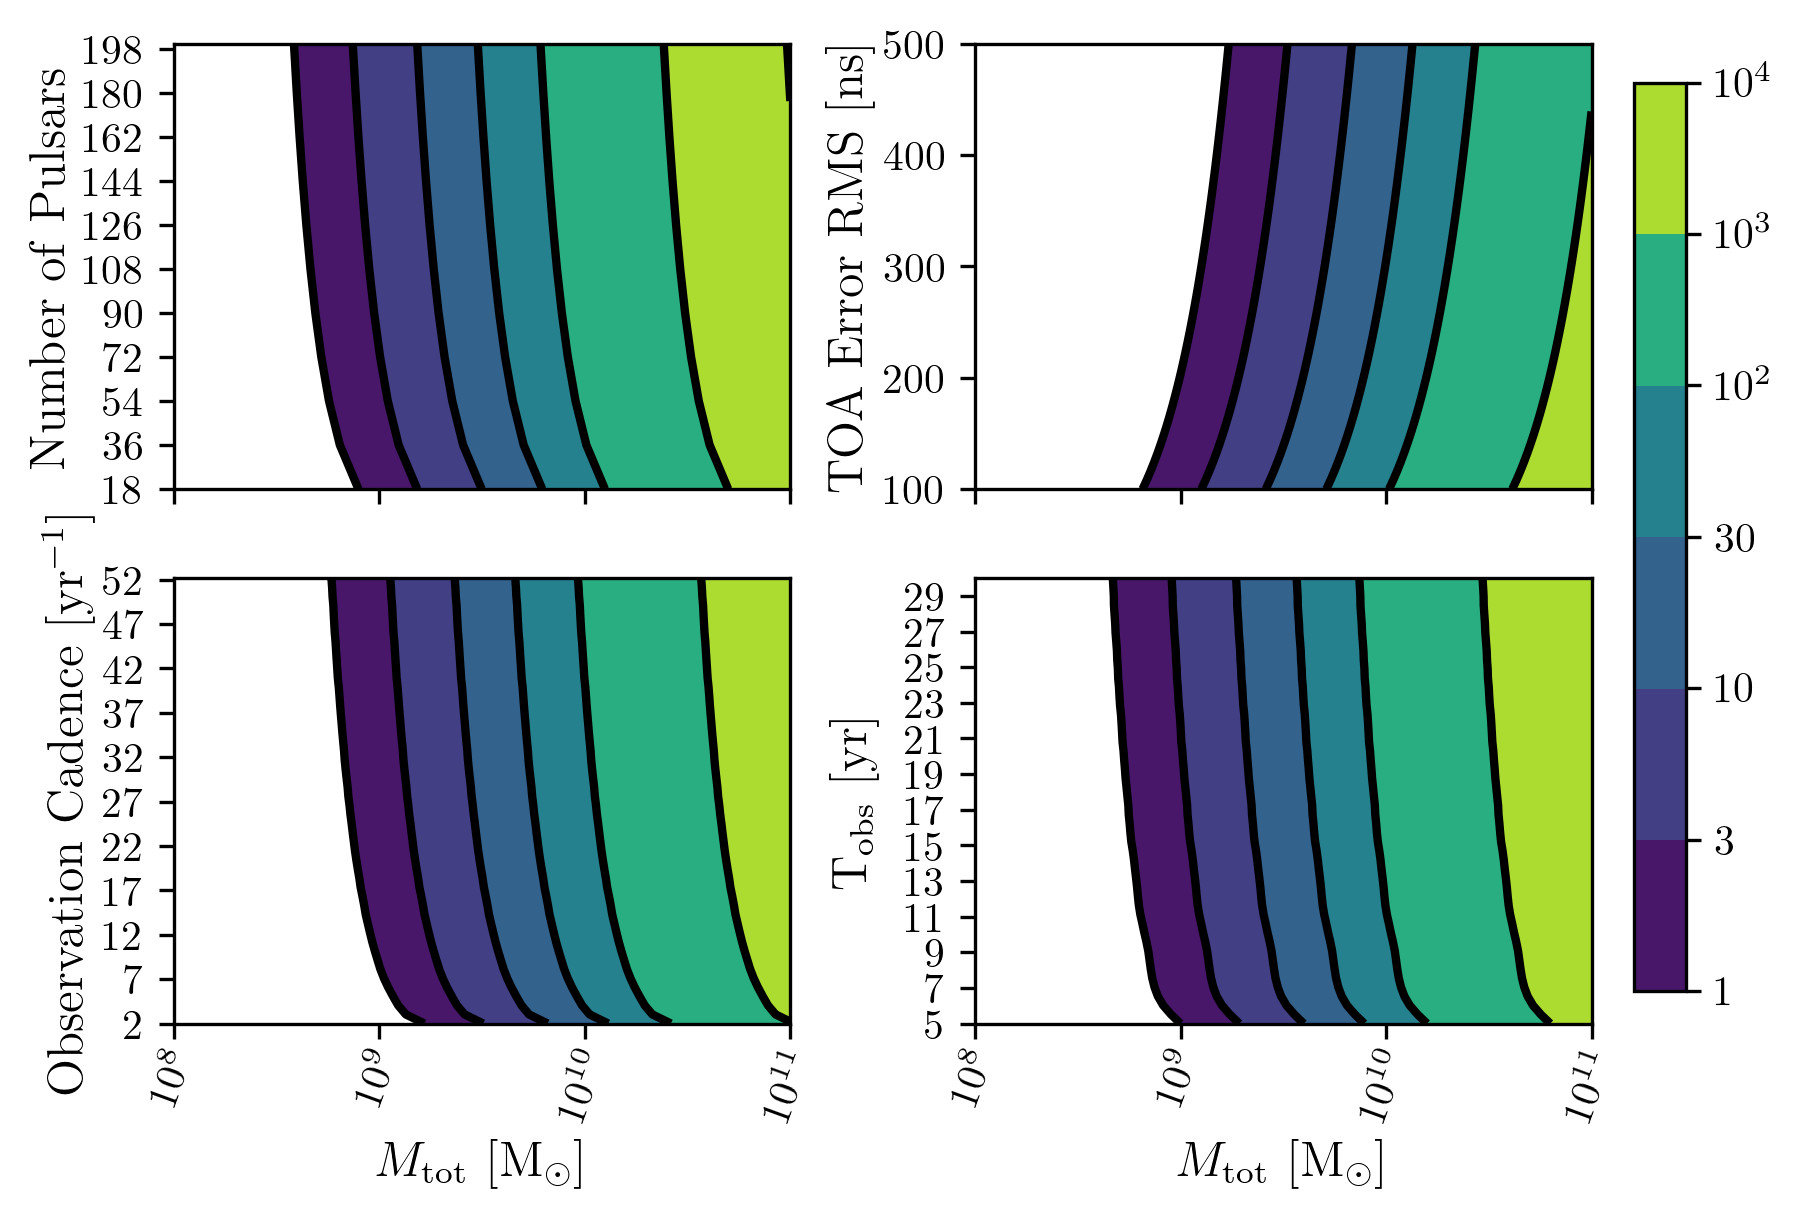

In [118]:
figsize = get_fig_size(scale=1.0)
fig, axes = plt.subplots(2,2,figsize=figsize)

loglevelMax=4.0
hspace = .2
wspace = .3

ii = 0
for i in range(np.shape(axes)[0]):
    for j in range(np.shape(axes)[1]):
        if ii == (np.shape(axes)[0]*np.shape(axes)[1])-1:
            Plot_SNR('M',sample_x_array[ii],var_ys[ii],
                     sample_y_array[ii],SNR_array[ii],
                     fig=fig,ax=axes[i,j],
                     logLevels_max=loglevelMax,
                     hspace=hspace,wspace=wspace,
                     xticklabels_kwargs={'rotation':70,'y':0.02},
                     ylabels_kwargs={'labelpad':5})
        elif ii == (np.shape(axes)[0]*np.shape(axes)[1])-2:
            Plot_SNR('M',sample_x_array[ii],var_ys[ii],
                     sample_y_array[ii],SNR_array[ii],
                     fig=fig,ax=axes[i,j],display=False,display_cbar=False,
                     logLevels_max=loglevelMax,
                     hspace=hspace,wspace=wspace,
                     xticklabels_kwargs={'rotation':70,'y':0.02},
                     ylabels_kwargs={'labelpad':2})
        else:
            Plot_SNR('M',sample_x_array[ii],var_ys[ii],
                     sample_y_array[ii],SNR_array[ii],
                     fig=fig,ax=axes[i,j],display=False,display_cbar=False,x_axis_label=False,
                     logLevels_max=loglevelMax,
                     hspace=hspace,wspace=wspace,
                     xticklabels_kwargs={'rotation':70,'y':0.02},
                     ylabels_kwargs={'labelpad':2})
        ii += 1